# Homework 09 - IANNwTF - January 11, 2023

### Preparation

Imports, Activate GPU

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import imageio
import PIL
import time

from IPython import display

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  #Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    #Virtual devices must be set before GPUs have been initialized
    print(e)

### 2.1.1 Load the Dataset

In [8]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [9]:
#Creates a folder to download the original drawings into.
#We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
if not os.path.isdir('npy_files') :
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

#You can limit the amount of images you use for training by setting :
train_images = images[:10000]
#You should also define a samller subset of the images for testing..

### TODO
test_images = images[10000:12000]
###

#Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on


In [10]:
#create training and test tf.datasets
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)

<TakeDataset element_spec=TensorSpec(shape=(784,), dtype=tf.uint8, name=None)>
<MapDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>


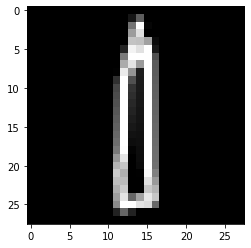

In [11]:
#print original and wanted shape and show image 
temp = test_ds.take(1)
print(temp)
temp = temp.map(lambda image: (tf.cast(tf.reshape(image, [28,28,1]), tf.float32)))
print(temp)
for elem in temp:
  plt.gray()
  plt.imshow(elem[:,:,0])

### 2.1.2 Prepare the Dataset

In [12]:
def prepare_image_data(ds, batch_size = 32) :
  #Prepare data for model  
  ds = ds.map(lambda img: (tf.cast(img, tf.float32)))
  ds = ds.map(lambda img:(tf.reshape(img, [28,28,1])))
  ds = ds.map(lambda img: ((img/128.)-1.))  
  #cache 
  ds = ds.cache()
  #shuffle, batch, prefetch our dataset
  ds = ds.shuffle(len(ds))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(1000)
  return ds

In [13]:
train_ds = prepare_image_data(train_ds)
test_ds = prepare_image_data(test_ds)

### 2.2 The model - GAN

In [14]:
class Discriminator(tf.keras.models.Model) :
  def __init__(self) :
    super(Discriminator, self).__init__()
    #list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="disc_loss"),
      tf.keras.metrics.BinaryCrossentropy(name="disc_bce", from_logits=True) ]

    self.discriminator = [
      tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same', input_shape=[28, 28, 1]),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(32, (3,3), strides=(2, 2), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.3),
      
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1, activation='sigmoid') ]
  
  @tf.function
  def call(self, x, training=True) :
    for layer in self.discriminator :
      x = layer(x, training=training)
    return x

  #function to reset the metric values
  def reset_metrics(self) :
      for metric in self.metrics :
          metric.reset_states()

In [15]:
class Generator(tf.keras.models.Model) :
  def __init__(self) :
    super(Generator, self).__init__()

    #list of loss and accuracy for training 
    self.metrics_list = [
      tf.keras.metrics.Mean(name="gen_loss"),
      tf.keras.metrics.BinaryCrossentropy(name="gen_bce", from_logits=True) ]

    self.generator = [
      tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
      tf.keras.layers.BatchNormalization(),
      #https://towardsdatascience.com/leaky-relu-vs-relu-activation-functions-which-is-better-1a1533d0a89f#:~:text=The%20Leaky%20ReLU%20Activation%20Function,introduced%20by%20Maas%20et%20al.
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Reshape((7,7,256)),

      tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(1,1), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),

      tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(1,1), padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.LeakyReLU(),
      
      tf.keras.layers.Conv2DTranspose(filters= 1, kernel_size=(3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh') ]

  @tf.function
  def call(self, x, training=True) :
    for layer in self.generator:
      x = layer(x, training=training)
    return x

  #function to reset the metric values
  def reset_metrics(self) :
      for metric in self.metrics :
          metric.reset_states()

Testing

<class 'tensorflow.python.framework.ops.EagerTensor'> (1, 28, 28, 1)


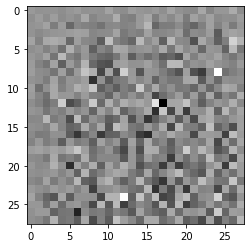

In [16]:
#test generator
sample_generator = Generator()
generated_image = sample_generator(tf.random.normal([1, 100]), training=False)
plt.imshow(generated_image[0, :, :, 0])
print(type(generated_image), generated_image.shape)

In [17]:
#test discriminator on generated image
test_discriminator = Discriminator()
result = test_discriminator(generated_image)
print(result)

tf.Tensor([[0.10469932]], shape=(1, 1), dtype=float32)


### Hyperparameters for model and training

In [18]:
#hyperparameters
BATCH_SIZE = 256
EPOCHS = 50
LOSS_FUNC = tf.keras.losses.BinaryCrossentropy()

noise_dim = 100
num_examples_to_generate = 4
noise = tf.random.normal([1, 100])
seed = tf.random.normal([num_examples_to_generate, noise_dim])

gen_optimizer = tf.keras.optimizers.Adam(0.001)
disc_optimizer = tf.keras.optimizers.Adam(0.001)

#initialize models 
generator = Generator()
discriminator = Discriminator()

### 2.3.1 Training

In [19]:
### Image generation for training visualization
def generate_image(model, test_input) :
  # `training` set to False.
  # This is so all layers run in inference mode (batchnorm)
  # get image from generator
  predictions = model(test_input, training=False)

  # plot image
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')
  plt.show()

Loss computations:

In [20]:
def discriminator_loss(real_output, fake_output, loss_func) :
  #compute loss for discriminator
  real_loss = loss_func(tf.ones_like(real_output), real_output)
  fake_loss = loss_func(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output, loss_func) :
  #compute loss for generator
  return loss_func(tf.ones_like(fake_output), fake_output)

In [21]:
@tf.function
def train_step(images, loss_func) :
  #Noise
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  #Training
  with tf.GradientTape() as gen_tape :
    with tf.GradientTape() as disc_tape :
      generated_images = generator(noise)
      real_output = discriminator(images)
      fake_output = discriminator(generated_images)
      gen_loss = generator_loss(fake_output, loss_func)
      disc_loss = discriminator_loss(real_output, fake_output, loss_func)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  #update loss metric
  discriminator.metrics[0].update_state(disc_loss)
  generator.metrics[0].update_state(gen_loss)
  #for all metrics except loss, update states (accuracy etc.)
  for metric in discriminator.metrics[1:] :
    metric.update_state(tf.ones_like(real_output), real_output)
    metric.update_state(tf.zeros_like(fake_output), fake_output)
  for metric in generator.metrics[1:] :
    metric.update_state(tf.ones_like(fake_output), fake_output)

  # Return a dictionary mapping metric names to current value
  disc_metrics = {m.name : m.result() for m in discriminator.metrics}
  gen_metrics = {m.name : m.result() for m in generator.metrics}
  return  gen_metrics , disc_metrics

def test_step(images, loss_func) :
  generated_images = generator(noise, training=False)
  real_output = discriminator(images, training=False)
  fake_output = discriminator(generated_images, training=False)
  gen_loss = generator_loss(fake_output, loss_func)
  disc_loss = discriminator_loss(real_output, fake_output, loss_func)

  #update loss metric
  discriminator.metrics[0].update_state(disc_loss)
  generator.metrics[0].update_state(gen_loss)
  #for all metrics except loss, update states (accuracy etc.)
  for metric in discriminator.metrics[1:] :
    metric.update_state(tf.ones_like(real_output), real_output)
    metric.update_state(tf.zeros_like(fake_output), fake_output)
  for metric in generator.metrics[1:] :
    metric.update_state(tf.ones_like(fake_output), fake_output)

  #return a dictionary mapping metric names to current value
  disc_metrics = {m.name : m.result() for m in discriminator.metrics}
  gen_metrics = {m.name : m.result() for m in generator.metrics}
  return  gen_metrics , disc_metrics

In [22]:
import datetime
def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [23]:
def training(train_data, test_data, loss_function, epochs, train_summary_writer, val_summary_writer):
  # train models
  for epoch in range(epochs):
    print()
    print(f"Epoch {epoch}:")
    
    for data in train_data:
        gen_metrics, disc_metrics = train_step(data, loss_function)
                                    
    print("Discriminator")
    print([f"{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])
    
    # logging the validation metrics to the log file with tensorboard
    with train_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
  
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()
    
    # test models
    for data in test_data:
        gen_metrics, disc_metrics = test_step(data, loss_function)
                                
    print("Discriminator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(disc_metrics.keys()), list(disc_metrics.values()))])
    print("Generator")
    print([f"test_{key}: {value}" for (key, value) in zip(list(gen_metrics.keys()), list(gen_metrics.values()))])

    # show generated images                                              
    generate_image(generator, seed)
    
    # logging the validation metrics to the log file with tensorboard
    with val_summary_writer.as_default():
        for metric in generator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        for metric in discriminator.metrics:
            tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
    
    # reset metrics in models
    discriminator.reset_metrics()
    generator.reset_metrics()

### 2.3.1 Training 

In [24]:
tf.keras.backend.clear_session()


Epoch 0:
Discriminator
['disc_loss: 0.4147278964519501', 'disc_bce: 0.7500303387641907']
Generator
['gen_loss: 3.199018955230713', 'gen_bce: 0.6101959943771362']
Discriminator
['test_disc_loss: 1.0823408365249634', 'test_disc_bce: 0.5136027932167053']
Generator
['test_gen_loss: 8.821283340454102', 'test_gen_bce: 0.6930733323097229']


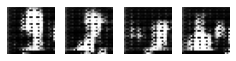


Epoch 1:
Discriminator
['disc_loss: 0.27852943539619446', 'disc_bce: 0.697564959526062']
Generator
['gen_loss: 4.227817535400391', 'gen_bce: 0.653335452079773']
Discriminator
['test_disc_loss: 1.92669677734375', 'test_disc_bce: 0.5533038973808289']
Generator
['test_gen_loss: 6.504241466522217', 'test_gen_bce: 0.6923984289169312']


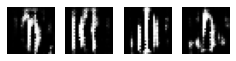


Epoch 2:
Discriminator
['disc_loss: 0.2693886160850525', 'disc_bce: 0.6957590579986572']
Generator
['gen_loss: 4.507188320159912', 'gen_bce: 0.6551933884620667']
Discriminator
['test_disc_loss: 4.729583740234375', 'test_disc_bce: 0.6698693633079529']
Generator
['test_gen_loss: 9.087523460388184', 'test_gen_bce: 0.6930909752845764']


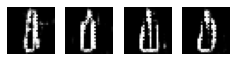


Epoch 3:
Discriminator
['disc_loss: 0.27739962935447693', 'disc_bce: 0.6944884061813354']
Generator
['gen_loss: 4.784290313720703', 'gen_bce: 0.6568509936332703']
Discriminator
['test_disc_loss: 9.137369155883789', 'test_disc_bce: 0.6716457009315491']
Generator
['test_gen_loss: 11.858170509338379', 'test_gen_bce: 0.6931433081626892']


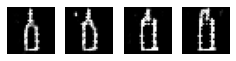


Epoch 4:
Discriminator
['disc_loss: 0.24303114414215088', 'disc_bce: 0.6908444166183472']
Generator
['gen_loss: 4.933964252471924', 'gen_bce: 0.6595205068588257']
Discriminator
['test_disc_loss: 4.790096759796143', 'test_disc_bce: 0.6536411643028259']
Generator
['test_gen_loss: 7.600791931152344', 'test_gen_bce: 0.6928974986076355']


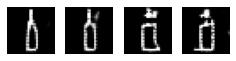


Epoch 5:
Discriminator
['disc_loss: 0.10141944885253906', 'disc_bce: 0.668571949005127']
Generator
['gen_loss: 6.125153541564941', 'gen_bce: 0.6776307821273804']
Discriminator
['test_disc_loss: 0.37115827202796936', 'test_disc_bce: 0.4001304805278778']
Generator
['test_gen_loss: 5.090902805328369', 'test_gen_bce: 0.6900752782821655']


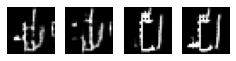


Epoch 6:
Discriminator
['disc_loss: 0.191013902425766', 'disc_bce: 0.6807570457458496']
Generator
['gen_loss: 5.681967258453369', 'gen_bce: 0.6680381894111633']
Discriminator
['test_disc_loss: 0.5389967560768127', 'test_disc_bce: 0.40428611636161804']
Generator
['test_gen_loss: 1.8232896327972412', 'test_gen_bce: 0.6156574487686157']


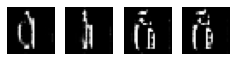


Epoch 7:
Discriminator
['disc_loss: 0.10376031696796417', 'disc_bce: 0.6682981252670288']
Generator
['gen_loss: 6.748622417449951', 'gen_bce: 0.6783718466758728']
Discriminator
['test_disc_loss: 2.065913677215576', 'test_disc_bce: 0.3429396450519562']
Generator
['test_gen_loss: 0.13729627430438995', 'test_gen_bce: 0.3494129776954651']


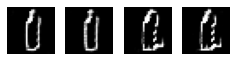


Epoch 8:
Discriminator
['disc_loss: 0.11467734724283218', 'disc_bce: 0.6705597043037415']
Generator
['gen_loss: 6.242196559906006', 'gen_bce: 0.6760881543159485']
Discriminator
['test_disc_loss: 1.3568637371063232', 'test_disc_bce: 0.523923397064209']
Generator
['test_gen_loss: 5.138072490692139', 'test_gen_bce: 0.690217137336731']


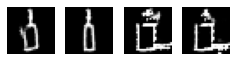


Epoch 9:
Discriminator
['disc_loss: 0.14193110167980194', 'disc_bce: 0.6730044484138489']
Generator
['gen_loss: 6.182885646820068', 'gen_bce: 0.6743065714836121']
Discriminator
['test_disc_loss: 2.086172342300415', 'test_disc_bce: 0.5760439038276672']
Generator
['test_gen_loss: 7.762031555175781', 'test_gen_bce: 0.6929346323013306']


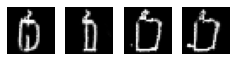


Epoch 10:
Discriminator
['disc_loss: 0.18338485062122345', 'disc_bce: 0.6807130575180054']
Generator
['gen_loss: 5.7780985832214355', 'gen_bce: 0.6679935455322266']
Discriminator
['test_disc_loss: 0.23230737447738647', 'test_disc_bce: 0.3551057279109955']
Generator
['test_gen_loss: 2.544128656387329', 'test_gen_bce: 0.654647707939148']


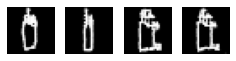


Epoch 11:
Discriminator
['disc_loss: 0.16358676552772522', 'disc_bce: 0.6777157783508301']
Generator
['gen_loss: 5.879761695861816', 'gen_bce: 0.670384407043457']
Discriminator
['test_disc_loss: 1.8290799856185913', 'test_disc_bce: 0.37593457102775574']
Generator
['test_gen_loss: 0.22737890481948853', 'test_gen_bce: 0.37215036153793335']


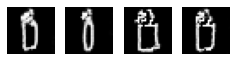


Epoch 12:
Discriminator
['disc_loss: 0.15394377708435059', 'disc_bce: 0.6759060621261597']
Generator
['gen_loss: 6.374966621398926', 'gen_bce: 0.6721013784408569']
Discriminator
['test_disc_loss: 0.5295995473861694', 'test_disc_bce: 0.40960007905960083']
Generator
['test_gen_loss: 1.9663333892822266', 'test_gen_bce: 0.6256100535392761']


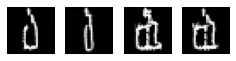


Epoch 13:
Discriminator
['disc_loss: 0.10829287022352219', 'disc_bce: 0.6696674227714539']
Generator
['gen_loss: 6.534121513366699', 'gen_bce: 0.6769730448722839']
Discriminator
['test_disc_loss: 0.7733721733093262', 'test_disc_bce: 0.43900495767593384']
Generator
['test_gen_loss: 1.714727520942688', 'test_gen_bce: 0.6071856617927551']


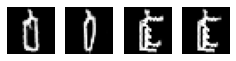


Epoch 14:
Discriminator
['disc_loss: 0.1277812272310257', 'disc_bce: 0.6721441149711609']
Generator
['gen_loss: 6.608696460723877', 'gen_bce: 0.6750474572181702']
Discriminator
['test_disc_loss: 1.5252180099487305', 'test_disc_bce: 0.3639131486415863']
Generator
['test_gen_loss: 0.2768039405345917', 'test_gen_bce: 0.3842467665672302']


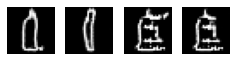


Epoch 15:
Discriminator
['disc_loss: 0.08915150165557861', 'disc_bce: 0.6663501858711243']
Generator
['gen_loss: 7.270195007324219', 'gen_bce: 0.6798500418663025']
Discriminator
['test_disc_loss: 2.182910203933716', 'test_disc_bce: 0.5974406599998474']
Generator
['test_gen_loss: 5.802489280700684', 'test_gen_bce: 0.6916386485099792']


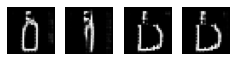


Epoch 16:


KeyboardInterrupt: ignored

In [25]:
train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")
training(train_ds, test_ds, LOSS_FUNC, EPOCHS, train_summary_writer, val_summary_writer) 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/